'Your codes look quite good but your interpretation are not really clear. You can check on the proposed \nsolutions from lecturer to get more knowledge in the interpretation\n\n'

# Mobility Data Analysis
1. Scoping
2.  Preprocress the data
3. Explolatory Data Analysis (EDA)
4. Generate user trips and other user attributes
5. Perfom analysis of user data to generate individual level metrics
6. Generate aggregate metrics such as OD

# Project Scoping

## Introduction
In this project, we study the mobility patterns within fictitious city called “the Red city”, whereby we moved through the following steps: 
### 1. Objectives
a. Data preprocessing (cleaning and filtering)

b. Explolatory Data Analysis (EDA)

c.Visualization and descriptive statistics

d.Generating individual based mobility patterns and attributes

### 3. Outputs
a. Plots (scatter plot, Heatmap plot)which show relationdhip between two variables and Distribution plot.

b. CSV file

c. Summary statistics

d. Correlation matrix

## Individual metrics to compute from the data. 

1.<b>Average number of trips per day:</b>
    
For each individual, the mean number of trips they take everyday  
    
2.<b>Radius of gyration(Rg):</b>

For a single day, Rg is the simple terms as the maximum distance a user travels. 

3.<b>Number of unique location:</b>

Number of unique location visited by a single user everyday

4.<b>Number of days:</b> 
    
A number of days user was activive


## Conceptual, methodological and design decisions 


#### Challenges faced during the study of the project:
1. To find the maximum distance travelled by each user in a day
2. To estimate the time travelled by each user per day.
3. To Define the number of locations per day for each individual.
3. Scaling data analysis
4. visual represantation of data 
5. To find appropriate data type for the analysis


## Considerations
1. Total time taken by each user
2. Total distance travelled
3. Total location reached

# Instructions
1. Please fill out all the places with "YOUR CODE HERE" with your code.
2. Fill in with your functions, in places where I ask you to do so.
3. Please answer all non-code questions where 

#  Python setup
Heree, we import all the required Python packages. In order to use, 
any other module which wasnt ```pip``` installed, such as ```mob_data_utils```,
you  can do the following:
```sys.append(full_path_to_module)```

In [ ]:
# utility libraries
import os
from pathlib import Path
from functools import wraps
import time
from datetime import datetime

# data processing libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Apache Spark Modules
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col,udf
from pyspark.sql.types import *

# plotting library
import seaborn as sns
sns.set_style("white")
sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth":1.25, "lines.markersize":8})

import sys
sys.path.append("/home/user/Downloads/mob_data_utils")

# local libraries (e.g., mob_data_utils)
# since mob_data_utils.py is in this dir
import mob_data_utils as ut

# Setup working directories
Its also important to setup commonly used diretories such as where you will be saving data

In [ ]:
# We can use CAPS for these variables since they are constants
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR.joinpath('data')
OUTPUTS_DIR = BASE_DIR.joinpath('outputs')

In [ ]:
# Setup global parameters and variables
MISC_PROCESSING_PARAMS = {'distance_threshold': 2, 'min_unique_locs': 2,'datetime_col': 'datetime',
                        'userid': 'user_id','x': 'lon', 'y': 'lat'}

# Data preprocessing.
Often, after all the data has been  acquired, thee next step is to do some preprocessing on the raw data. 
The objectives of this task will vary depending on the data analysis goals but some of them include following:
- **Sanitize the data:** this data cleaning has to be done carefully to avoid introducing errors but its often a necessary step. It can involve dropping some unnecessary variables/columns. Renaming some columns to something which makes more sense. Dropping some observations. For instance, in this analysis where location and time-stamp is important, dropping all observations with no time-stamp and no location is required.
- **Create new variables:**. If necessary, this is also the time transform some variables from a format which is not convinient for your analysis. For instance, converting string time variables to datetime aware variables.
- **Combine datasets:** If you have more than one dataset, during preprocessing, you can also combine several datasets into one. For instance, we have the CDR transations which have no location details. We bring in the location details from another file.
- **Filtering based on columns and observations:** This can be done through any of the stages mentioned above but its worth mentioning that often, you may drop some columns which arent useful for your analysis. Also, you may drop some observations based on some conditions depending on your analysis needs.

Unlike in other data collection domains such as surveys where you can have standard data processing steps, in the data science space where your dataset can be anything, there are no hard and fast rule for preprocessing and data cleaning. It will be a case by case basis depending on your analysis goals. Also, preprocessing isnt necessarily a linear process: depending on what results you get downstream, you can go back and modify the preprocesisng steps. In this project, we have the ```preprocess_cdrs_using_spark``` which takes raw cdrs and saves to a CSV a processed dataset. Alternatively, we can return a Spark DataFrame.

In [ ]:
def rename_sdf(df, mapper=None):
    ''' Rename column names of a dataframe
        mapper: a dict mapping from the old column names to new names
        Usage:
            df.rename({'old_col_name': 'new_col_name', 'old_col_name2': 'new_col_name2'})
            df.rename(old_col_name=new_col_name)
    '''
    for before, after in mapper.items():
        df = df.withColumnRenamed(before, after)
    
    return df

In [ ]:
def preprocess_cdrs_using_spark(file_or_folder=None, number_of_users_to_sample=None,
                                output_csv=None, date_format='%Y%m%d%H%M%S',
                                debug_mode=True, loc_file=None, save_to_csv=False,
                                userid_col="user_id"):
    """
    In this function, we perfom some basic preprocessing such as below:
    1. rename columns
    2. change some data types
    3. Add location details
    Eventually, we will sample the data to use for our analysis
    :param data_folder:
    :param output_csv_for_sample_users:
    :return:
    """

     # ==============================
    # LOAD DATA
    # ==============================
    spark = SparkSession.builder.master("local[*]")\
        .config('spark.driver.memory', '4g')\
        .appName("HELLO Spark")\
        .getOrCreate()
    df = spark.read.csv(path=file_or_folder,header=True)
    df = df.repartition(10)
    if debug_mode:
        dfs = df.sample(0.01,seed=1990)
        df = dfs

    # ==================================================
    # RENAME, DROP COLUMNS, ADD DATETIME AND DROP NULLS
    # ===================================================
    cols_to_rename = {}
    for c in df.columns:
        if " " in c:
            cols_to_rename[c] = c.replace(" ", "_")
    df = rename_sdf(df, mapper=cols_to_rename)
    df = df.withColumnRenamed("last_calling_cellid", "cell_id")
    df = df.drop('cdr_type', 'call_duration')
    df = df.filter(df.user_id.isNotNull())
    df = df.filter(df.cdr_datetime.isNotNull())
    
    add_datetime = udf(lambda x: datetime.strptime(x, date_format), TimestampType())
    add_date = udf(lambda x: datetime.strptime(x, date_format), DateType())

    df = df.withColumn('datetime', add_datetime(col('cdr_datetime')))
    df =  df.withColumn('date', add_date(col('cdr_datetime')))

    # ==================================================
    # ADD LOCATION THROUGH JOIN
    # ===================================================
    dfLoc =pd.read_csv(loc_file)
    dfLoc =  dfLoc.drop_duplicates(subset ="cell_id")
    sdfLoc = spark.createDataFrame(dfLoc)

    df = sdfLoc.join(df,on="cell_id",how='inner')#.show(truncate=False)

    df = df.filter(df.user_id.isNotNull())
    
    # ==================================================
    # SAMPLE USERS
    # ===================================================
    all_users = df.select(userid_col).distinct().collect()
    random_userid_list = [i[userid_col] for i in random.choices(all_users, k=number_of_users_to_sample)]
    dfu = df.filter(df.user_id.isin(random_userid_list))For each individual, the mean number of trips they take everyday 
    if save_to_csv:
        dfu.coalesce(1).write.csv(path=output_csv, header=True)
    else:
        return dfu


In [ ]:
# Use DATA_DIR and joinpath as its been used above to create
# full path for simulated_cdrs and loc file
loc_file = "/home/user/Downloads/simulated_locs.csv"
cdrs_dir = "/home/user/Downloads/simulated_cdrs"
num_users = 1000
debug = True

# call preprocess_cdrs_using_spark here
# use cache() at the end of the like this preprocess_cdrs_using_spark.cache()
# Learn about what cache does using spark here:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.cache.html#pyspark.sql.DataFrame.cache
dfu = preprocess_cdrs_using_spark(file_or_folder=str(cdrs_dir), number_of_users_to_sample=num_users,
                                date_format='%Y%m%d%H%M%S',debug_mode=False, 
                                  loc_file=loc_file, save_to_csv=False).cache()

In [ ]:
dfu.show(mean)

+-------+-------+------------------+------------------+--------------+-------------------+-------------------+----------+
|cell_id|site_id|               lat|               lon|  cdr_datetime|            user_id|           datetime|      date|
+-------+-------+------------------+------------------+--------------+-------------------+-------------------+----------+
|  14361|   S258|-8.538153999999999|26.743633000000003|20180704121212|2285105686720187748|2018-07-04 12:12:12|2018-07-04|
|  14361|   S258|-8.538153999999999|26.743633000000003|20180704121148|2285105686720187748|2018-07-04 12:11:48|2018-07-04|
|  14361|   S258|-8.538153999999999|26.743633000000003|20180708120129|6325367414188041047|2018-07-08 12:01:29|2018-07-08|
|  14361|   S258|-8.538153999999999|26.743633000000003|20180702093040|2285105686720187748|2018-07-02 09:30:40|2018-07-02|
|  14361|   S258|-8.538153999999999|26.743633000000003|20180708120129|6325367414188041047|2018-07-08 12:01:29|2018-07-08|
|  14361|   S258|-8.5381

# Explolatory Data Analysis (EDA)
Whether the end result of your project is to produce a statistical report or 
to build a prediction model to be put in production, EDA is an essential stage in any data science project. EDA can be defined as 
the process of performing initial investigations on data so as to discover patterns,to spot anomalies,
to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.
It is a good practice to understand the data first and try to gather as many insights from it. 
EDA is all about making sense of data before using the data for the intended use (e.g., build ML models, perfom statisitcal analysis). 

Again, there arent hard and fast rules on how to perfom EDA but some of the specific quesitons you would like to answer are as folloes:
- For each variable in the data, whats its distribution? Is it skewed? Whats its data type? Is it an approapriate  data type fopr my analysis. Are there any outliers?
- Whats the relationship between variables?

In this project, we will use the ```explore_data``` and explore what functions Spark has for basic EDA.

In [ ]:
# The data type
dfu.summary()

DataFrame[summary: string, cell_id: string, site_id: string, lat: string, lon: string, cdr_datetime: string, user_id: string]

In [ ]:
def explore_data_with_spark(df=None, output_plot_file=None, output_heatmap=None):
    """
    Lets do a quick exploration of the data by generating the following:
    1. Number of days in the data
    2. User call count stats
    3. Weekday and hour calling patterns
    """
    
    # =====================================
    # CALCULATE THE NUMBER OF DAYS IN DATA
    # =====================================
    
    dates_rows = df.select("date").distinct().collect()
    sorted_dates = sorted(dates_rows)
    diff = sorted_dates[-1]['date']-sorted_dates[0]['date']
    num_days = diff.days
 
    # =====================================
    # GENERATE WEEKDAY AND HOUR CALL COUNT
    # =====================================

    add_hr = udf(lambda x: x.hour)          # Define Spark udf to get hour from the datetime column                                 ##YOUR CODE
    add_wkday = udf(lambda x: x.weekday())   # Define Spark udf to get hour from the datetime column
    day_dict = {'0':"Mon",'1':"Tue",'2':"Wed",'3':"Thu",'4':"Fri",'5':"Sat",
                    '6':"Sun"}   
    df = df.withColumn('hr', add_hr(col('datetime')))
    df =  df.withColumn('wkday', add_wkday(col('date')))
    pdf = df.groupBy('wkday','hr').count().toPandas()
    
    pdf['weekDay'] = pdf['wkday'].map(lambda x: day_dict[x])
    pdf = pdf.drop('wkday',  axis = 1)
    pdf = pdf.pivot(index='weekDay', columns='hr', values='count')

    plt.figure(figsize=(7,5))
    fig1 = sns.heatmap(pdf)
    plt.savefig(output_heatmap)

    # =====================================
    # NUMBER OF CALLS FOR EACH USER
    # =====================================

    df_grp_user = df.groupBy('user_id').count().toPandas()

    plt.figure(figsize=(10,8))
    sns.displot(data=df_grp_user, x='user_id',y='count')
    plt.savefig(output_plot_file)
   
    df_grp_day = df.groupBy('user_id', 'date').count().toPandas()

    mean = df_grp_day['count'].mean()
    median = df_grp_day['count'].median()
For each individual, the mean number of trips they take everyday 
    return mean, median, len(df_grp_day['date'].unique())


## Project Task

### Generate more summary statistics
Please complete the function below.

In [ ]:
def summary_stats_for_user_events(spark_df, out_stats):
    """
    In this function, the goal is to take a big Spark
    DataFrame, group users and count each users events, 
    convert to pandas DataFrame and generate summary stats
    :param: spark_df: preprocessed spark dataframe with data for multiple users
    :param: out_stats: CSV file path to save  the summary stats
    """
    # group user and count number of events
    # convert resulting spark dataframe to pandas
    pdf = spark_df.groupBy("user_id").count().toPandas()
    # change column "count" to num_events,remember that pdf is a pandas DataFrame
    pdf = pdf.rename(columns = {"count": "num_events"})
    
    # generate summary stats using pandas describe() function
    # use property T to transpose the describe results and convert them
    # into a DataFrame like this: pd.DataFrame(transposed describe results).reset_index()
    # Dont forget to rese_index()
    pdf_sum_stats = pd.DataFrame(pdf.describe().T).reset_index()
    
    # remove the first row which has value "count"
    # you can use list indexing to achieve this
    pdf_sum_stats.drop('count', inplace=True, axis=1)
    
    # Rename the column index into something informative. For instance, "Stat"
    pdf_sum_stats =  pd.DataFrame(pdf_sum_stats).rename(columns = {"index": "Stat"})
    
    # Rename the percentiles in numbers to something better
    # first, declare a dict with old and new names
    # next, update the Stats column using the pd.Series.map() function
    d = {"25%":"quarter","50%":"half","75%":"threeQuarter."}
    pdf_sum_stats =  pdf_sum_stats.rename(columns = d)
    
    print("="*40)
    print("This is the summary statistics table.")
    print("="*40)
    print()
    # please print  the table  below
    print(pdf_sum_stats)
    
    # Now  save the summary stats to CSV
    pdf_sum_stats.to_csv("out_stats.csv")

In [ ]:
summary_stats_for_user_events(dfu,"out_stats")

This is the summary statistics table.

         Stat    mean        std  min  quarter  half  threeQuarter.    max
0  num_events  11.151  21.078722  1.0      1.0   3.0           10.0  279.0


###  Interpreting EDA results and applying them in downstreat work
Please answer the question below. You should answer in this same notebook.

**EDA-Question-1**: Given the distribution of number of events per user. When it comes to characterizing user mobility patterns such as number  of trips. Do you think we should utilize all users regardless of number of events?

A. Yes, we can use all users regardless of number of events.

B. No, we should filter out some users

**Your answer:**

B. No, we should filter out some users


**EDA-Question-2**: If you answered B, please answer the following questions on filtering?
1. How do determine threshold for filtering?

####  By aggregating user_id by number of events 

2. Which users do you filter out? 

#### Removing repeated user_id

# Generate individual based mobility patterns and attributes
As we noted in the project  instructions, the focus of this analysis is to understand mobility patterns 
on individual users. Although, generating trips  and understanding their distribution is crucial for this project, due to time constraints, we will start with simple mobility metrics. Namely:
- **Radius of gyration(Rg):**  For a single day, Rg can be defined in simple terms as the maximum distance a user travels. We can then compute ```avg_Rg``` based on all Rg from the user's data. This metric ```avg_Rg``` is what we will compute.
- **Number of unique locations visited everyday:** As the name suggests, this is simply, the count of unique locations an individual visits everyday. Given multiple days data, we will compute the ```avg_locs_per_day```

In addition to the mobility metric above, we will report the ```number of days``` a user was activive which will help us understand how much we should trust user data. 

For this task, we will utilize functions in the ```mob_data_utils``` module which were already created to generate  the required metrics above. You can import ```mob_data_utils``` like this to use my code: 
```import mob_data_utils as ut```

## Define functions to generate user attributes

In [ ]:
def get_basic_user_mob_attributes(df):
        """
        In this funciton, we generate some basic user attributes 
        to help further explore the data and also report on 
        individual mobility metrics.
        :param df: Pandas DataFrame of single user data
        :return:
        """
        # get, datecol, x(lon), y(lat) from the MISC_PROCESSING_PARAMS variable
        datetimecol = MISC_PROCESSING_PARAMS["datetime_col"]
        x =  MISC_PROCESSING_PARAMS["x"]
        y =  MISC_PROCESSING_PARAMS["y"]
        
        # use if condition to 
        if  'date' not in df.columns:
            # add date column in case its not  there
            # use the datetimecol to achieve this
            df['date'] = df[datetimecol].map(lambda x: day_dict[x])
        
        # get a list of all  days/dates in ascending order
        # first, sort the dates and then get only unique dates
        dates = np.unique(sorted(df['date'] ))
        # this dictionary will keep, for each, a count of unique locations visited
        # initialize this dict with dates as keys and values set to 0
        # you can use list comprehension idea though this is a dictionary
        # Hint, create a list  of unique dates when initializing this dict
        unique_locs_by_day = dict.fromkeys(dates,0)
        
        # create a dictionary just like above but this one will keep
        # maximum distance travelled for each day
        dates_dist = dict.fromkeys(dates, 0)
        
        # Loop through the dates_dist dictionary
        for k,l in dates_dist.items():
            # Filter the input df so that we only get data for this date
            dfd = df[df['date'].isin([k])]

            # get number of unique locations for this day
            uniq_xy = ut.va_generate_unique_locs(df=dfd, x=x, y=y)
            # add to the unique_locs_by_day dict, this date based on how
            # you initialized your loop, the value is the number of
            # unique locations visited
            unique_locs_by_day[k]+= len(uniq_xy)


            # distances travel
            if len(uniq_xy) > 1:
                dist_mtx = ut.va_distance_matrix(uniq_xy)
                # From the distance matrix above, get only columns with "to"
                # in it, use list comprehension with if condition
                req_cols = [i for i in dist_mtx.columns if 'to' in i]
                # get max value from the distance matrix above
                # first, subset the dist_mtx DataDrame by selecting only req_cols
                # then, get values from the resulting DataFrame which you should
                # pass into np.max() function
                # put the resulting max value into the dates_dist dict with this 
                # date as key
                # this can be achieved in a single line of code or multiple lines
                dates_dist[k] = np.max(np.max(dist_mtx[req_cols]))
            else:
                # if number of unique locations is less than or equal to 1
                # then set the value in the dates_dist dict accordingly
                dates_dist[k] = 0
        
        # return dates_dist, unique_locs_by_day, number of days
        return dates_dist, unique_locs_by_day, len(dates)

In [ ]:
def generate_basic_user_attributes_with_pandas(df, outcsv, num_events_threshold=None):
    """
        In this funciton, we generate some basic user attributes 
        to help further explore the data and also report on 
        individual mobility metrics.
        :param df: Pandas DataFrame with multiple user data
        :return:
        """
    # get userid col name from  MISC_PROCESSING_PARAMS
    userid = MISC_PROCESSING_PARAMS["userid"]
    # generate a list of unique userid's
    user_list = list(df[userid].unique())
    # initialize an empty list to hold user  data
    user_data = []
    
    # Loop through all users and generate their attributes
    for k,user in enumerate(user_list):
        # Filter the input df so that we only get data for this user
        df_user = df[df[userid] == user]
        
        if num_events_threshold:
            if df_user.shape[0] < num_events_threshold:
                continue
            else:
                # call the get_basic_user_mob_attributes function here
                a, b, c = get_basic_user_mob_attributes(df = df_user)
        else:
             # call the get_basic_user_mob_attributes function here
                a, b, c = get_basic_user_mob_attributes(df = df_user)
        
        # get the attributes
        # create a dictionary with the following keys: 'userid', 'usage_days', 'mean_locs_day'
        # use appropriate numpy functions to compute  mean as required and set them as values
        # in the dict
        user_att = {'userid':user, 'usage_days':c, 'mean_locs_day': np.mean(list(b.values())),
                    'avr_rg': np.mean([np.mean(el) for el in a.values()])}
        # add user_att to the user_data list
        user_data.append(user_att)
    
    print("="*40)
    print("This is the top  10  rows of the DataFrame.")
    print("="*40)
    print()
    
    # create DataFrame using user_data and save it to file (2 lines of code)
    dfr = pd.DataFrame(user_data)
    dfr.to_csv('out_data.csv')

    # please print only the head of  the DataFrame below 
    return dfr.head(10)

In [ ]:
out_data=DATA_DIR.joinpath("out_data.csv")
generate_basic_user_attributes_with_pandas(df=dfu.toPandas(), outcsv=outcsv, num_events_threshold=MISC_PROCESSING_PARAMS.get('distance_threshold'))

This is the top  10  rows of the DataFrame.



,userid,usage_days,mean_locs_day,avr_rg
0,2285105686720187748,9,1.666667,10.439069
1,6325367414188041047,1,1.000000,0.000000
2,4312077593387115972,14,2.285714,3.505988
3,2047588643295968419,1,1.000000,0.000000
4,6149054706199418364,10,1.000000,0.000000
5,131060159559257826,2,1.500000,2.649951
6,1878053517877845879,5,1.400000,0.224169
7,2297148774922677732,2,1.000000,0.000000
8,3757152352454152557,2,1.000000,0.000000
9,2843442371943627932,5,2.200000,1.638524


## Create outputs from the CSV file of user attributes

### QUESTION-PART1: DEFINE A FUNCTION WITH FOLLOWING PROPERTIES:
- **Function name:** generate_outputs_from_csv()
- **Inputs:** csv file which you save from generate_basic_user_attributes_with_pandas function above
- **Inside the function:** use any plotting library (e.g., seaborn as we have used in this course) to generate a distribution plot of ```Radius of gyration(Rg)```.  Make sure your function shows the plot inline when it runs.
- **Function output:** The function doesnt have to return anything
- **Show plots in function:** Make sure you use plt.show() as required to show plots inside the function

<Figure size 648x432 with 0 Axes>

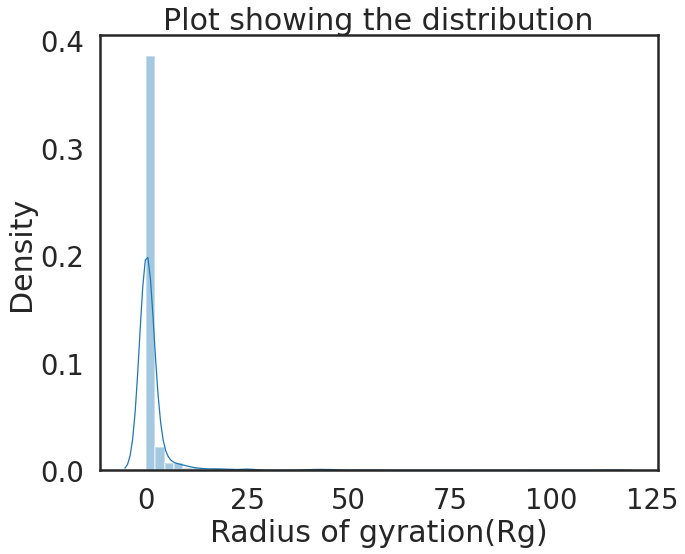

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

def generate_outputs_from_csv(dfr):
    plt.figure(figsize=(10,8))
    sns.distplot(dfr["avr_rg"])
    plt.xlabel('Radius of gyration(Rg)')
    plt.ylabel('Density')
    plt.title('Plot showing the distribution')
    plt.show() 
    
df_out = pd.read_csv('out_data.csv')
plt.figure(figsize=(9,6))
generate_outputs_from_csv(df_out)

### QUESTION-PART2: INTERPRET THE RESULTS
Write a few sentences to interpret the plot ```Radius of gyration(Rg)``` that you generated. Based on how it looks, do you think its normally distributed? 

#### Interpretation 
1. The plot is not normally distributed
2. The results are skewed on the right side of the plot


### QUESTION: EXPLORE RELATIONSHIP BETWEEN ```avg_Rg``` and ```avg_locs_per_day```
Using the CSV that you saved above, perfom analyis (you dont have to use a function)
- Use a relevant plot to show relationship between the two variables

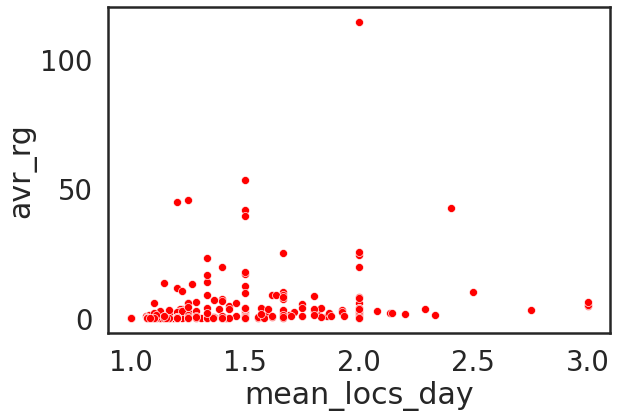

In [ ]:
plt.figure(figsize=(9,6))
sns.scatterplot(data=df_out, y="avr_rg", x="mean_locs_day", color = "red");

- Report the correlation coefficient between the two variables

               mean_locs_day    avr_rg
mean_locs_day       1.000000  0.343845
avr_rg              0.343845  1.000000


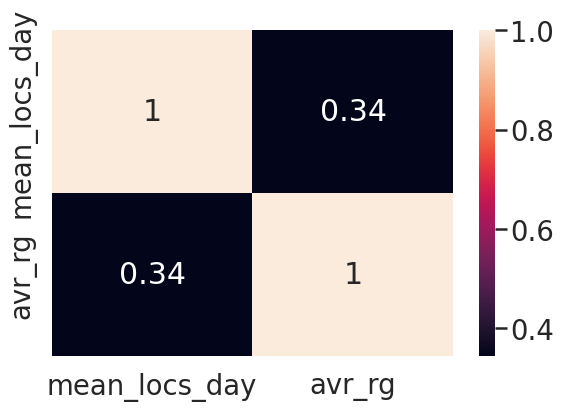

In [ ]:
data_out = df_out[["mean_locs_day","avr_rg"]]
print(data_out.corr())
plt.figure(figsize=(9,6))
sns.heatmap(data_out.corr(), annot = True)
plt.show()

- Write a few sentences to interpret the results

1. There is positive weak correlation between avg_Rg and avg_locs_per_day
2. As the distance travelled by individual increase the number of location increase.
3. Heatmap visualize the correlation 
4. From the scatter plot, we see that we have some outleirs

# Submission Files
  - Jupyter Notebook itself after running everything so that plots  are saved 
  - An HTML output